In [10]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/content/drive")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [13]:
#import the data and filter the signals
# This could be change depending if you download or not the data

ECG_folder = "/content/drive/MyDrive/WP_02_data/1_batch_extracted"
ECG_folder_2batch = "/content/drive/MyDrive/WP_02_data/2_batch_extracted"

tabular_data = pd.read_excel("/content/drive/MyDrive/WP_02_data/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(r"/content/drive/MyDrive/WP_02_data/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)


Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [16]:
print("Missing values in signals (NumPy array):", np.isnan(signals).sum())
print("\nMissing values per column in tabular_data (Pandas DataFrame):\n", tabular_data.isnull().sum())

Missing values in signals (NumPy array): 0

Missing values per column in tabular_data (Pandas DataFrame):
 ECG_patient_id                   0
age_at_exam                      0
sex                              0
weight                          74
height                          74
trainning_load                   1
sport_classification             0
sport_ability                    0
AV block                         0
ST abnormality                   0
Complete BBB                     0
Prolonged QTc                    0
Uncontrolled hypertension        0
Supraventricular arrhythmias     0
Ventricular arrhythmias          0
Baseline ECG abnormalities       0
Valvular heart diseases          0
Symptomatic patients             0
dtype: int64


In [17]:
# Remove 'weight' and 'height' columns
print("Shape of tabular_data before dropping columns:", tabular_data.shape)
tabular_data = tabular_data.drop(columns=['weight', 'height'])
print("Shape of tabular_data after dropping 'weight' and 'height' columns:", tabular_data.shape)

# Drop rows where 'trainning_load' is missing
print("Shape of tabular_data before dropping 'trainning_load' NaNs:", tabular_data.shape)
tabular_data = tabular_data.dropna(subset=['trainning_load'])
print("Shape of tabular_data after dropping 'trainning_load' NaNs:", tabular_data.shape)

print("\nMissing values after all operations (should all be zero):\n", tabular_data.isnull().sum())

Shape of tabular_data before dropping columns: (526, 18)
Shape of tabular_data after dropping 'weight' and 'height' columns: (526, 16)
Shape of tabular_data before dropping 'trainning_load' NaNs: (526, 16)
Shape of tabular_data after dropping 'trainning_load' NaNs: (525, 16)

Missing values after all operations (should all be zero):
 ECG_patient_id                  0
age_at_exam                     0
sex                             0
trainning_load                  0
sport_classification            0
sport_ability                   0
AV block                        0
ST abnormality                  0
Complete BBB                    0
Prolonged QTc                   0
Uncontrolled hypertension       0
Supraventricular arrhythmias    0
Ventricular arrhythmias         0
Baseline ECG abnormalities      0
Valvular heart diseases         0
Symptomatic patients            0
dtype: int64


,ECG_patient_id,age_at_exam,sex,weight,height,trainning_load,sport_classification,sport_ability,AV block,ST abnormality,Complete BBB,Prolonged QTc,Uncontrolled hypertension,Supraventricular arrhythmias,Ventricular arrhythmias,Baseline ECG abnormalities,Valvular heart diseases,Symptomatic patients
0,3,20.095825,0,60.0,166.0,2.0,1,0,0,0,0,0,0,0,1,0,0,0
1,4,51.646817,0,84.0,180.0,2.0,1,0,0,1,0,0,1,0,0,0,0,0
2,5,40.936345,0,104.0,180.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0
3,6,14.201232,0,80.0,174.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0
4,7,16.607803,1,47.0,148.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,549,15.167693,1,60.0,163.0,2.0,1,0,0,0,0,0,0,0,1,0,0,0
522,550,27.764545,0,89.0,176.0,4.0,1,1,0,0,0,0,0,0,0,0,0,0
523,551,15.780972,0,72.0,183.0,3.0,1,1,0,0,0,0,0,0,0,0,0,0
524,552,22.661191,0,72.0,172.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0


# Task
Extract statistical features (mean, standard deviation, min, max, and range) for each of the 12 leads from the preprocessed ECG signals, then store these features in a DataFrame.

## Feature Engineering for Each Signal

### Subtask:
Extract statistical features (mean, standard deviation, min, max, and range) for each of the 12 leads from the preprocessed ECG signals, then store these features in a DataFrame.


**Reasoning**:
The user wants to extract statistical features from each ECG signal lead and store them in a DataFrame. I will iterate through the signals, then through each of the 12 leads, calculate the mean, standard deviation, min, max, and range for each lead, and store these features in a list of dictionaries. Finally, I will convert this list into a Pandas DataFrame.



In [24]:
all_features = []

for i, signal in enumerate(signals):
    signal_features = {}
    for lead_idx in range(12):
        lead_data = signal[:, lead_idx]
        signal_features[f"lead_{lead_idx}_mean"] = np.mean(lead_data)
        signal_features[f"lead_{lead_idx}_std"] = np.std(lead_data)
        signal_features[f"lead_{lead_idx}_min"] = np.min(lead_data)
        signal_features[f"lead_{lead_idx}_max"] = np.max(lead_data)
        signal_features[f"lead_{lead_idx}_range"] = np.max(lead_data) - np.min(lead_data)
    all_features.append(signal_features)

features_df = pd.DataFrame(all_features)

print("Shape of features_df:", features_df.shape)
print("First 5 rows of features_df:")
print(features_df.head())

Shape of features_df: (526, 60)
First 5 rows of features_df:
   lead_0_mean  lead_0_std  lead_0_min  lead_0_max  lead_0_range  lead_1_mean  \
0     0.000104    0.066597   -0.310537    0.167532      0.478069    -0.000084   
1     0.000086    0.069998   -0.164119    0.403728      0.567846     0.000114   
2     0.000003    0.083163   -0.584669    0.505331      1.090001    -0.000822   
3     0.000337    0.140573   -0.215975    0.952721      1.168696     0.000742   
4     0.000389    0.058135   -0.214709    0.388610      0.603319     0.000960   

   lead_1_std  lead_1_min  lead_1_max  lead_1_range  ...  lead_10_mean  \
0    0.168502   -0.395334    1.069164      1.464498  ...      0.001512   
1    0.148821   -0.217286    0.648216      0.865501  ...     -0.000937   
2    0.317832   -0.543208    2.536743      3.079951  ...     -0.002830   
3    0.234030   -0.705724    1.483469      2.189193  ...      0.001299   
4    0.288077   -0.570878    1.922471      2.493349  ...     -0.000917   

   lead

## Unsupervised Anomaly Detection on Signal Features

### Subtask:
Apply an unsupervised anomaly detection algorithm (e.g., Isolation Forest, One-Class SVM, or Local Outlier Factor) to the extracted feature vectors to identify statistically different ECG signals.


**Reasoning**:
To perform unsupervised anomaly detection, I will import the IsolationForest model, initialize it, fit it to the extracted features, and then predict anomaly scores and outlier labels.



**Reasoning**:
The `ValueError` occurred because the `features_df` was modified by adding the 'anomaly_score' column before calling `isolation_forest.predict`, causing a mismatch in feature names between fit and predict. To fix this, I will first calculate both the `anomaly_score` and `is_outlier` using the original `features_df` (without the new columns) and then add these new columns to the DataFrame.



In [26]:
from sklearn.ensemble import IsolationForest

# Initialize the IsolationForest model
# Using default parameters for now, contamination can be tuned if needed.
isolation_forest = IsolationForest(random_state=42)

# Fit the model to the features_df
isolation_forest.fit(features_df)

# Predict anomaly scores for each sample
anomaly_scores = isolation_forest.decision_function(features_df)

# Predict whether each sample is an outlier (-1 for outliers, 1 for inliers)
outlier_predictions = isolation_forest.predict(features_df)

# Add the new columns to features_df after all predictions are made
features_df['anomaly_score'] = anomaly_scores
features_df['is_outlier'] = outlier_predictions

print("Shape of features_df after anomaly detection:", features_df.shape)
print("First 5 rows of features_df with anomaly scores and labels:")
print(features_df.head())

Shape of features_df after anomaly detection: (526, 62)
First 5 rows of features_df with anomaly scores and labels:
   lead_0_mean  lead_0_std  lead_0_min  lead_0_max  lead_0_range  lead_1_mean  \
0     0.000104    0.066597   -0.310537    0.167532      0.478069    -0.000084   
1     0.000086    0.069998   -0.164119    0.403728      0.567846     0.000114   
2     0.000003    0.083163   -0.584669    0.505331      1.090001    -0.000822   
3     0.000337    0.140573   -0.215975    0.952721      1.168696     0.000742   
4     0.000389    0.058135   -0.214709    0.388610      0.603319     0.000960   

   lead_1_std  lead_1_min  lead_1_max  lead_1_range  ...  lead_10_min  \
0    0.168502   -0.395334    1.069164      1.464498  ...    -0.953881   
1    0.148821   -0.217286    0.648216      0.865501  ...    -0.385115   
2    0.317832   -0.543208    2.536743      3.079951  ...    -0.755826   
3    0.234030   -0.705724    1.483469      2.189193  ...    -0.574989   
4    0.288077   -0.570878    1.9

In [27]:
num_outliers = features_df[features_df['is_outlier'] == -1].shape[0]
print(f"Total number of outlier signals identified: {num_outliers}")

Total number of outlier signals identified: 28


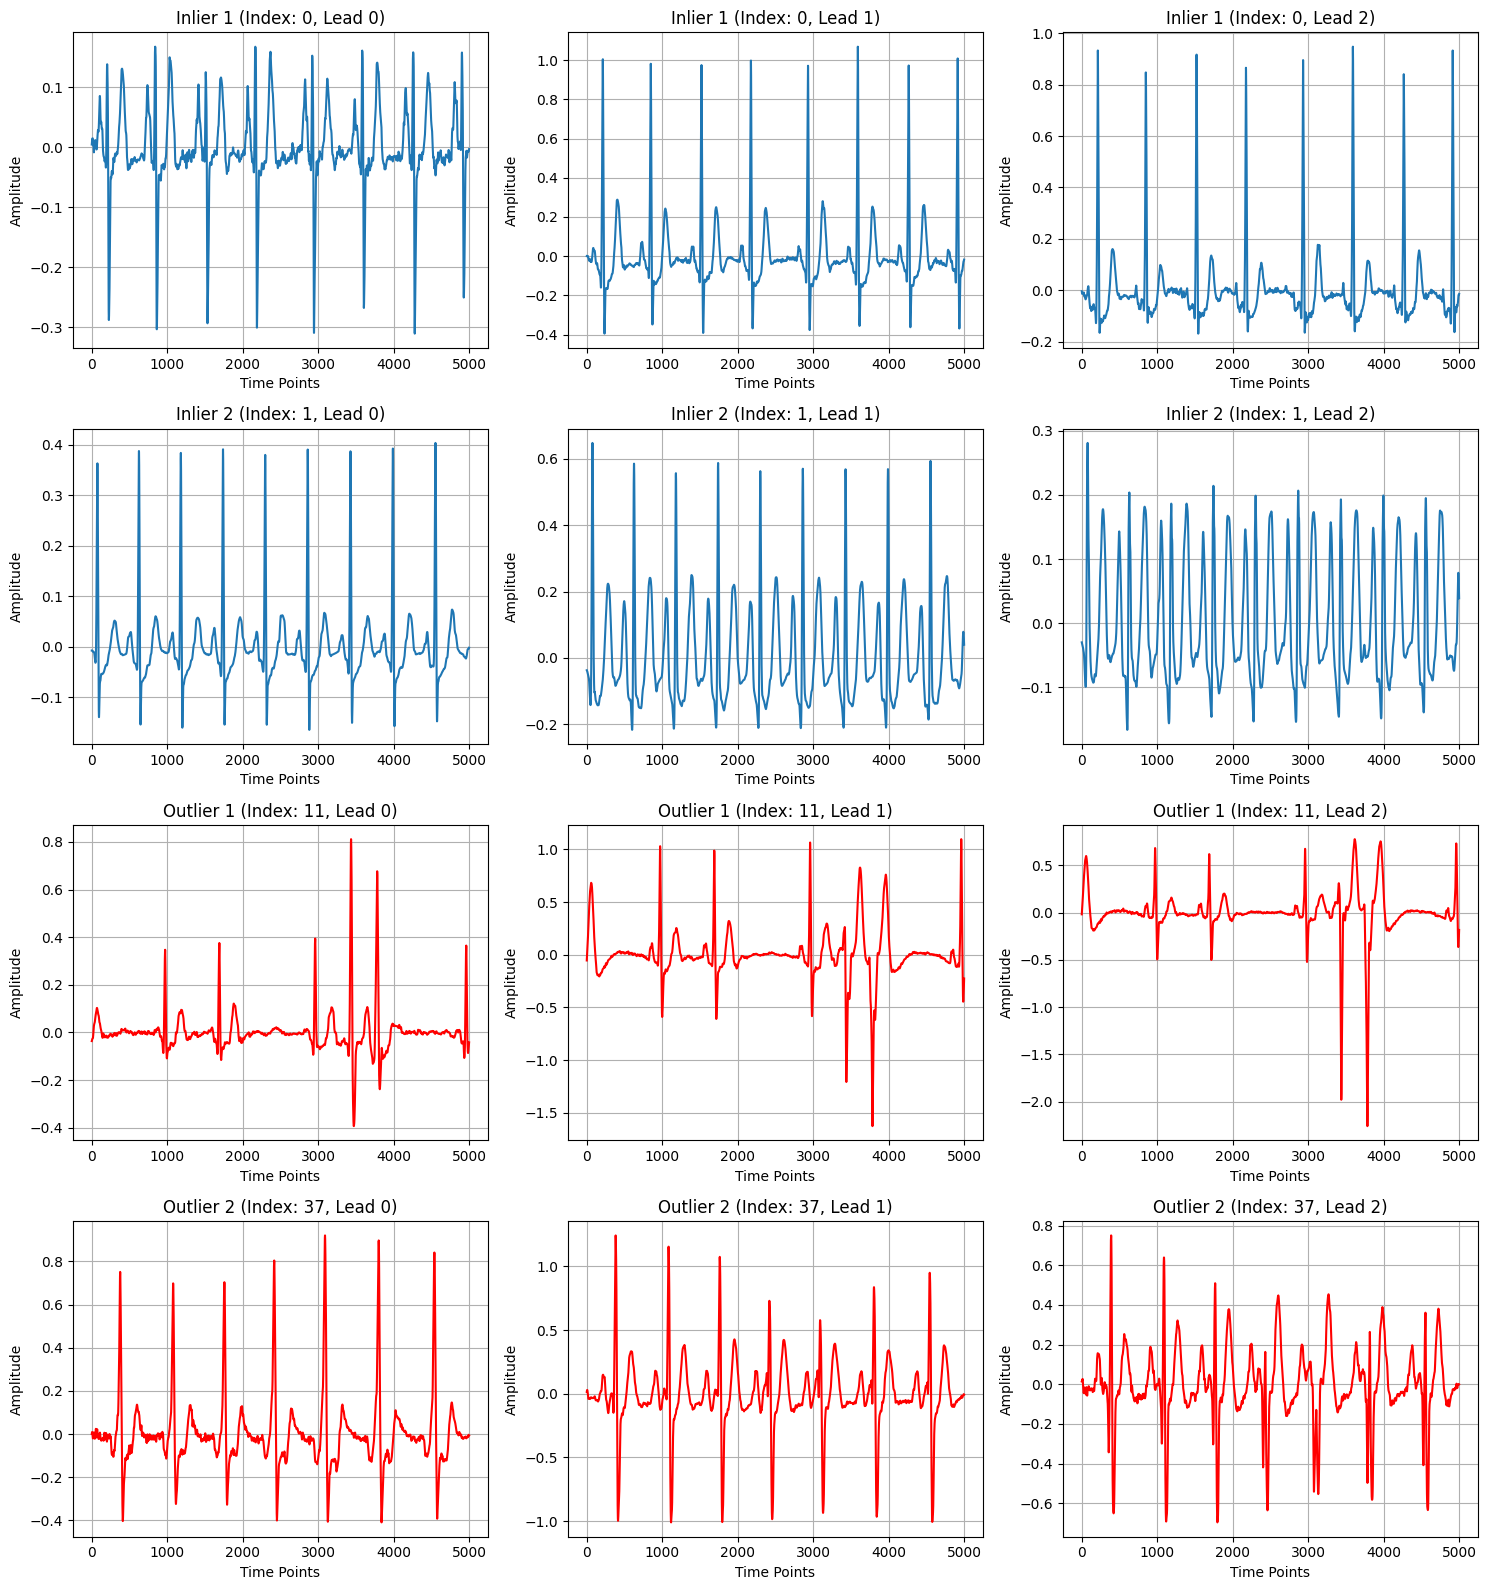

Displaying 2 inliers and 2 outliers across Leads [0, 1, 2].


In [30]:
import matplotlib.pyplot as plt

# Find the indices of a few inlier signals (e.g., first 2)
inlier_indices = features_df[features_df['is_outlier'] == 1].index[:2]
# Find the indices of a few outlier signals (e.g., first 2)
outlier_indices = features_df[features_df['is_outlier'] == -1].index[:2]

# Choose a few leads to plot (e.g., Leads 0, 1, 2)
leads_to_plot = [0, 1, 2]

num_inliers = len(inlier_indices)
num_outliers = len(outlier_indices)
num_leads_to_display = len(leads_to_plot)

# Calculate total number of rows for subplots
total_rows = (num_inliers + num_outliers)

# Adjust figure size for better visibility
plt.figure(figsize=(15, 4 * total_rows * num_leads_to_display / 3)) # Adjusted to scale vertically better

plot_idx = 1

# Plot inlier signals for selected leads
for s_idx, inlier_idx in enumerate(inlier_indices):
    inlier_signal_data = signals[inlier_idx]
    for l_idx, lead_num in enumerate(leads_to_plot):
        plt.subplot(total_rows, num_leads_to_display, plot_idx)
        plt.plot(inlier_signal_data[:, lead_num])
        plt.title(f'Inlier {s_idx+1} (Index: {inlier_idx}, Lead {lead_num})')
        plt.xlabel('Time Points')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plot_idx += 1

# Plot outlier signals for selected leads
for s_idx, outlier_idx in enumerate(outlier_indices):
    outlier_signal_data = signals[outlier_idx]
    for l_idx, lead_num in enumerate(leads_to_plot):
        plt.subplot(total_rows, num_leads_to_display, plot_idx)
        plt.plot(outlier_signal_data[:, lead_num], color='red')
        plt.title(f'Outlier {s_idx+1} (Index: {outlier_idx}, Lead {lead_num})')
        plt.xlabel('Time Points')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()

print(f"Displaying {num_inliers} inliers and {num_outliers} outliers across Leads {leads_to_plot}.")

## Visualization and Interpretation of Outlier Signals

### Subtask:
Visualize some of the identified outlier ECG signals and compare them with typical, 'regular' signals to understand why they were flagged as outliers.


## Summary:

### Data Analysis Key Findings

*   **Feature Extraction**: Statistical features (mean, standard deviation, minimum, maximum, and range) were successfully extracted for each of the 12 leads from 526 preprocessed ECG signals. These 60 features (12 leads \* 5 features/lead) were stored in a Pandas DataFrame named `features_df` with a shape of (526, 60).
*   **Anomaly Detection Setup**: An `IsolationForest` model was initialized and fitted to the `features_df` to identify statistically different ECG signals.
*   **Anomaly Detection Results**: The `IsolationForest` model successfully calculated an `anomaly_score` and `is_outlier` prediction for each ECG signal. These results were added as two new columns to `features_df`, increasing its shape to (526, 62). Outliers are labeled as -1 and inliers as 1.
*   **Technical Resolution**: A `ValueError` during the anomaly detection step, caused by modifying the DataFrame before prediction, was successfully resolved by ensuring that predictions (`anomaly_score` and `is_outlier`) were generated using the original feature set before adding them as new columns.

### Insights or Next Steps

*   The `features_df` now contains a rich set of statistical descriptors for each ECG signal, along with their respective anomaly scores and outlier labels, providing a robust foundation for further analysis.
*   The next logical step is to visualize some of the signals flagged as outliers (where `is_outlier` is -1) and compare them with typical signals (where `is_outlier` is 1) to understand the specific characteristics that led to their identification as anomalies. This will help in interpreting the nature of the detected outliers.
